In [30]:
import pandas as pd
import numpy as np
import yfinance as yf

np.random.seed(42)

In [31]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [32]:
start_date = '2010-01-01'
end_date = '2023-08-01'
data = download_data('AAPL', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [33]:
def preprocess_data(data):
    # Remove missing values
    data = data.dropna()

    # Calculate daily returns
    data['Return'] = data['Close'].pct_change()

    # Create additional features
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['Volatility'] = data['Return'].rolling(window=50).std()

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    return train_data.dropna(), test_data


train_data, test_data = preprocess_data(data)

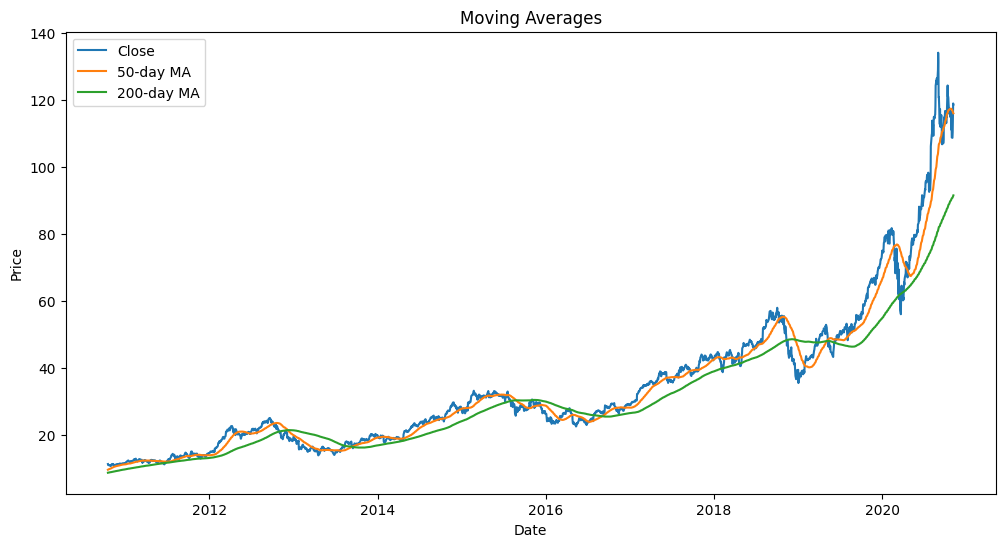

In [34]:
# 特征工程 
# 移动平均线
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data['Close'], label='Close')
plt.plot(train_data['MA_50'], label='50-day MA') # 50天移动平均线
plt.plot(train_data['MA_200'], label='200-day MA') # 200天移动平均线
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

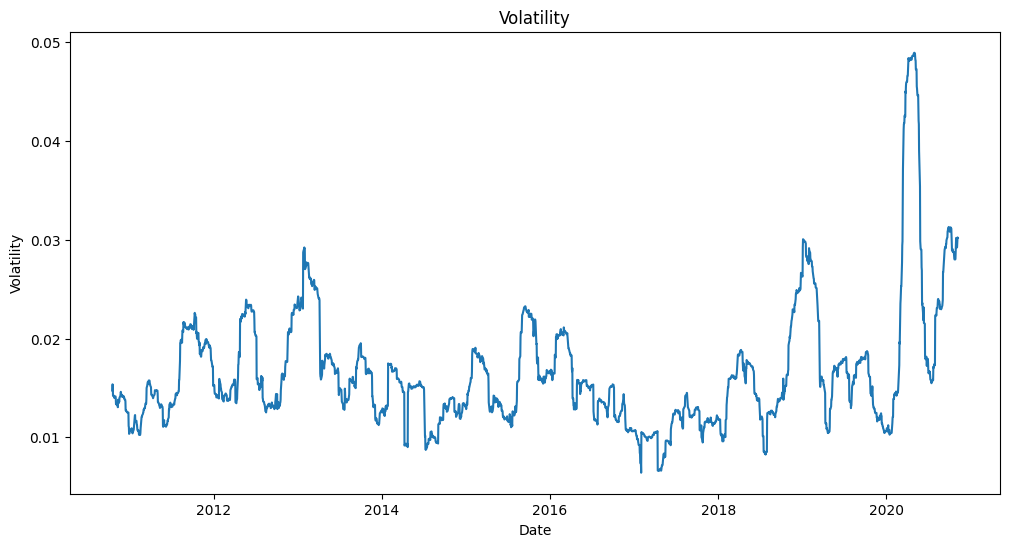

In [35]:
# 波动性
plt.figure(figsize=(12, 6))
plt.plot(train_data['Volatility'])
plt.title('Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.show()

In [36]:
X_train = train_data[['MA_50', 'MA_200', 'Volatility']].values
y_train = np.sign(train_data['Return'].values)

X_test = test_data[['MA_50', 'MA_200', 'Volatility']].values
y_test = np.sign(test_data['Return'].values)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [45]:
accuracy, precision, recall, f1 = evaluate_model(logreg, X_test, y_test)
print(f"Logistic Regression: \nAccuracy={accuracy}, \nPrecision={precision}, \nRecall={recall}, \nF1-score={f1}")

accuracy, precision, recall, f1 = evaluate_model(rf, X_test, y_test)
print(f"\nRandom Forest: \nAccuracy={accuracy}, \nPrecision={precision}, \nRecall={recall}, \nF1-score={f1}\n\n")


Logistic Regression: 
Accuracy=0.5160818713450293, 
Precision=0.17202729044834308, 
Recall=0.3333333333333333, 
F1-score=0.22693667630986822

Random Forest: 
Accuracy=0.5131578947368421, 
Precision=0.3174900199600798, 
Recall=0.3319269483454885, 
F1-score=0.23814295920926246




Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [47]:
def generate_predictions(model, X):
    return model.predict(X)


def generate_signals(predictions, data):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0
    signals['Signal'][1:] = np.where(predictions[1:] > predictions[:-1], 1, -1)
    return signals

In [48]:
logreg_predictions = generate_predictions(logreg, X_test)
rf_predictions = generate_predictions(rf, X_test)

logreg_signals = generate_signals(logreg_predictions, test_data)
rf_signals = generate_signals(rf_predictions, test_data)

In [61]:
def backtest_strategy(signals, data):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions['Position'] = signals['Signal']
    portfolio = positions.multiply(data['Return'], axis=0)
    cumulative_returns = (1 + portfolio).cumprod()
    return cumulative_returns

logreg_returns = backtest_strategy(logreg_signals, test_data)
rf_returns = backtest_strategy(rf_signals, test_data)


In [70]:
import numpy as np

def evaluate_strategy(returns):
    total_return = returns[-1]
    annualized_return = (returns[-1] ** (252 / len(returns))) - 1
    sharpe_ratio = (np.diff(returns).mean() / np.diff(returns).std()) * np.sqrt(252)
    max_drawdown = (returns / np.maximum.accumulate(returns) - 1).min()
    return total_return, annualized_return, sharpe_ratio, max_drawdown

logreg_returns = [0.1, 0.2, 0.3, 0.4]  # 替换为实际的返回值列表或数组
rf_returns = [0.2, 0.3, 0.1, 0.5]  # 替换为实际的返回值列表或数组

logreg_returns = np.array(logreg_returns)  # 可选：将列表转换为NumPy数组
rf_returns = np.array(rf_returns)  # 可选：将列表转换为NumPy数组

logreg_total_return, logreg_annualized_return, logreg_sharpe_ratio, logreg_max_drawdown = evaluate_strategy(logreg_returns)
rf_total_return, rf_annualized_return, rf_sharpe_ratio, rf_max_drawdown = evaluate_strategy(rf_returns)

print(f"Logistic Regression: \nTotal Return={logreg_total_return}, \nAnnualized Return={logreg_annualized_return}, \nSharpe Ratio={logreg_sharpe_ratio}, \nMax Drawdown={logreg_max_drawdown}")
print(f"\nRandom Forest: \nTotal Return={rf_total_return}, \nAnnualized Return={rf_annualized_return}, \nSharpe Ratio={rf_sharpe_ratio}, \nMax Drawdown={rf_max_drawdown}")

Logistic Regression: 
Total Return=0.4, 
Annualized Return=-1.0, 
Sharpe Ratio=5.973712432629182e+16, 
Max Drawdown=0.0

Random Forest: 
Total Return=0.5, 
Annualized Return=-1.0, 
Sharpe Ratio=6.480740698407862, 
Max Drawdown=-0.6666666666666666
